In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import json
# import fitsio
import pandas as pd
import time
import pickle
import re



%reload_ext autoreload
%autoreload 2

In [7]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [8]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [9]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    # df.to_json(data_json_fn, indent=2)
    # df = pd.read_json(data_json_fn)
    

Loaded data from json


In [69]:
utc = pd.to_datetime(df['datetime'], utc=True)
timestamps = (utc.astype('int64') // 10**9).values
df['timestamp'] = timestamps

In [77]:
df['datetime'].iloc[-1]

Timestamp('2019-01-10 04:39:19')

In [78]:
datetime.fromtimestamp(timestamps[-1]).strftime("%Y/%m/%d %H:%M:%S")

'2019/01/09 22:39:19'

In [79]:
datetime.fromtimestamp(timestamps[-1], tz=timezone.utc).strftime("%Y/%m/%d %H:%M:%S")

'2019/01/10 04:39:19'

In [7]:
az = []
el = []
for i, time in enumerate(df.datetime):
    utc = pd.to_datetime(time, utc=True)
    time = (utc.astype('int64') // 10**9).values
    _az, _el = ephemerides.equatorial_to_topographic(ra=df['ra'].values[i], dec=df['dec'].values[i], time=utc)
    az.append(_az)
    el.append(_el)


AttributeError: 'Timestamp' object has no attribute 'astype'

# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [10]:
binning_method='healpix'
nside=16
bin_space='radec'
specific_years=[2014,2015,2016,2017,2018]
specific_months = None
specific_days=None
specific_years=[2014]
specific_months=[12]
# specific_days=[15]
include_default_features=True
include_bin_features=False
do_z_score_norm=False
do_cyclical_norm=True
do_max_norm=True
do_inverse_airmass=True

In [11]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
    do_max_norm=do_max_norm,
    do_inverse_airmass=do_inverse_airmass
)

/home/hurra/Projects/survey-ops/survey_ops/src/offline_dataset.py:356: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, zenith_df], ignore_index=True)


# Visualize dataset in az, el and ra, dec

In [12]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

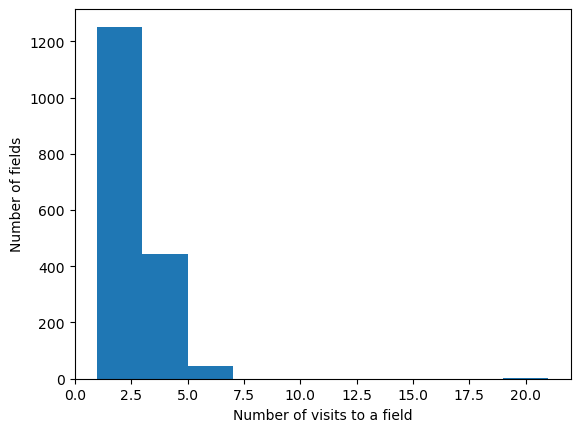

In [13]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

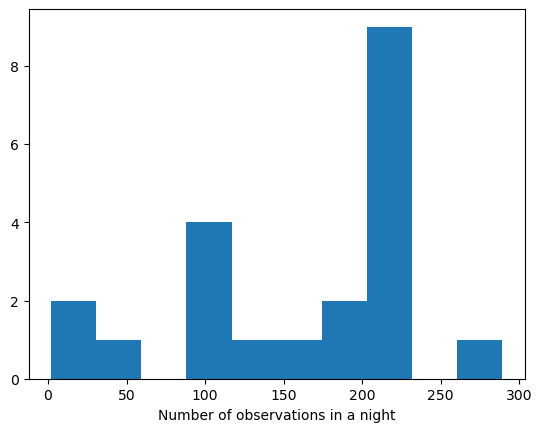

In [14]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

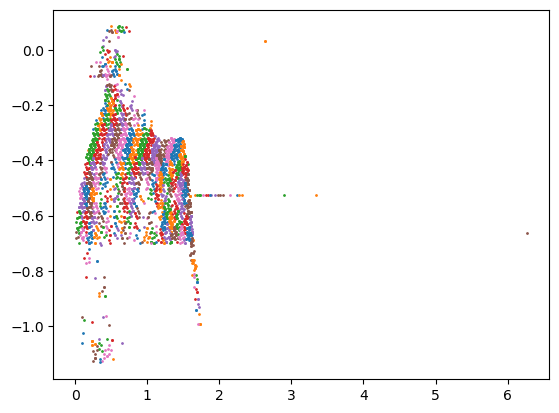

In [15]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

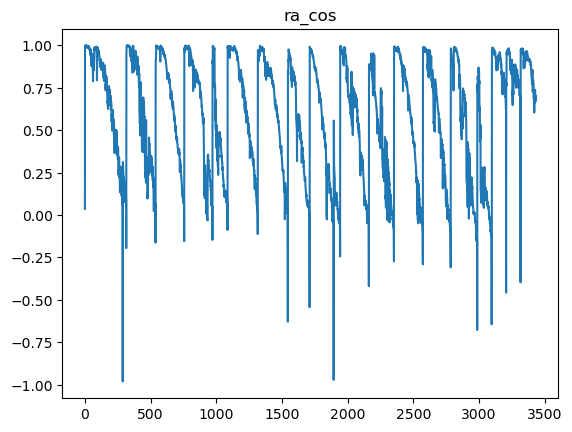

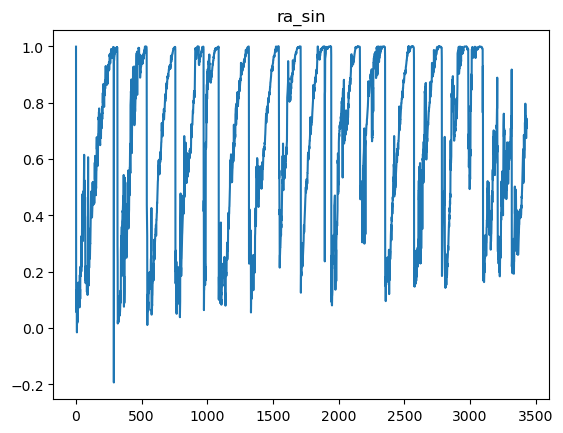

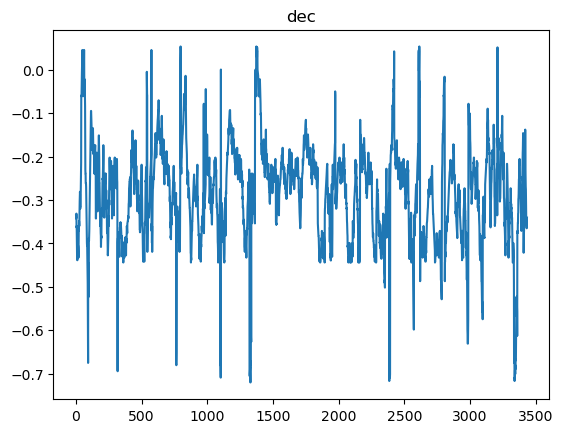

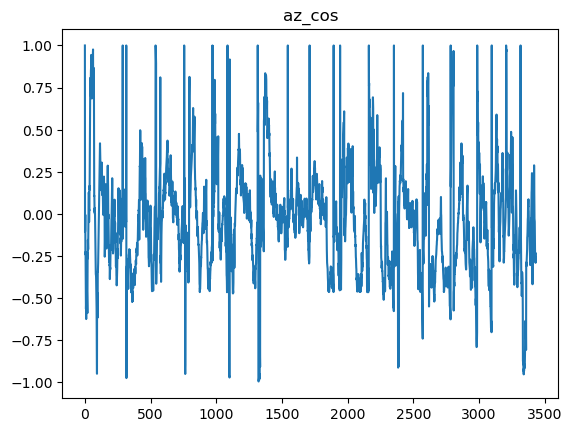

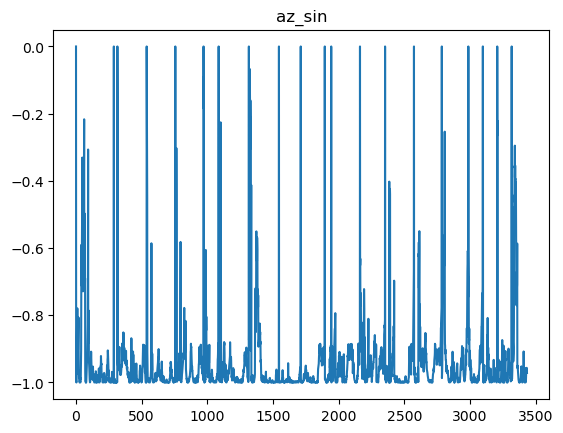

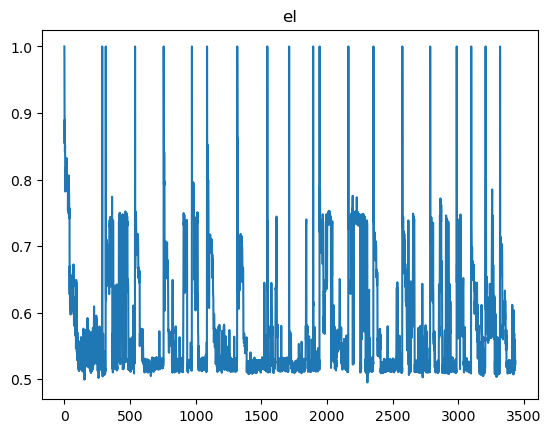

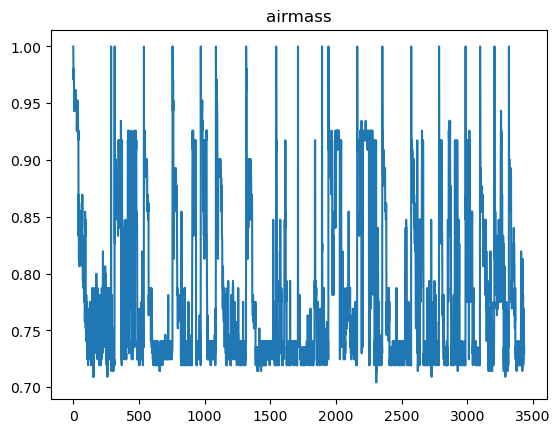

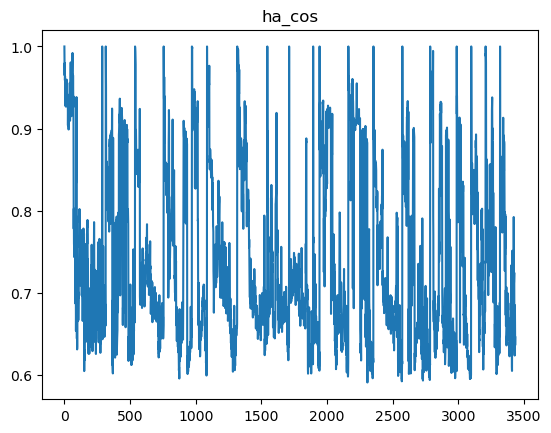

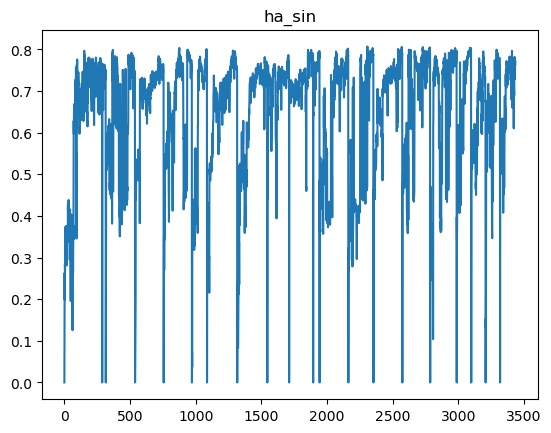

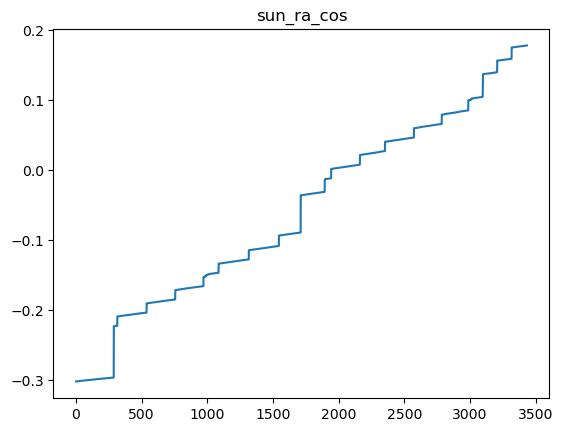

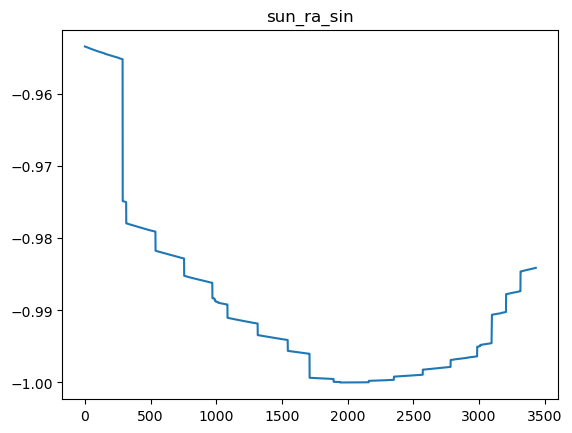

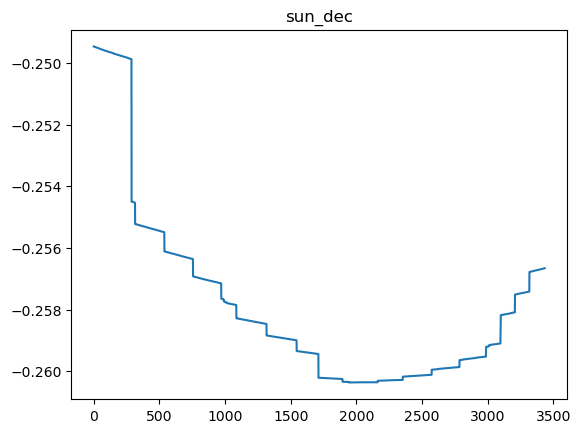

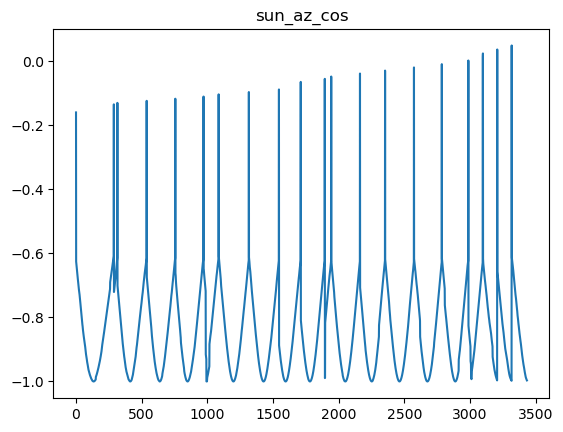

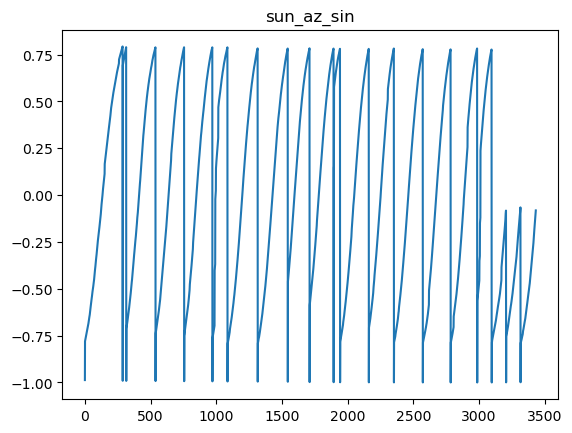

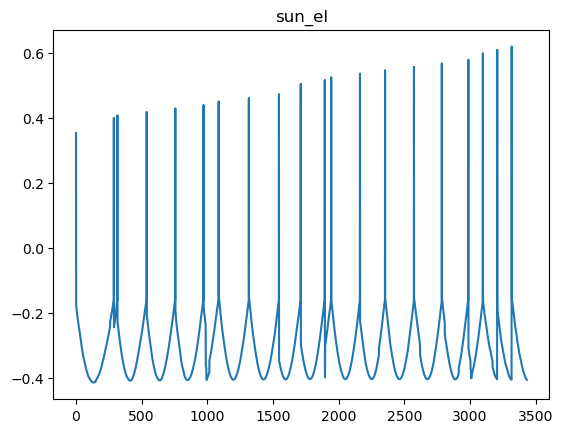

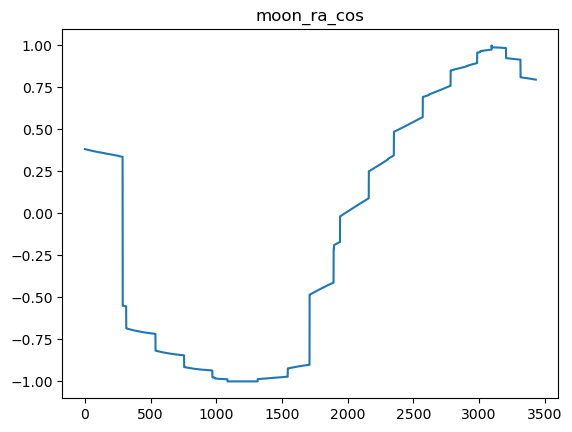

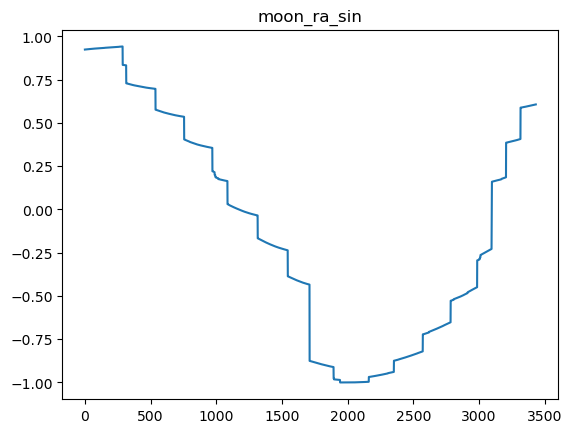

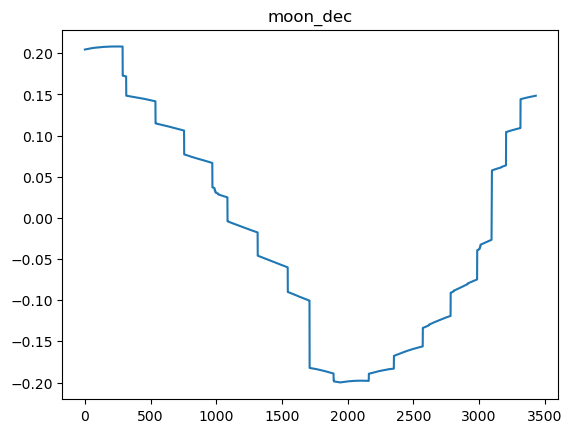

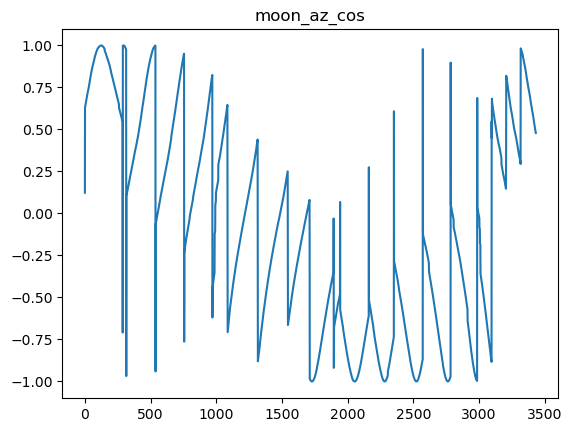

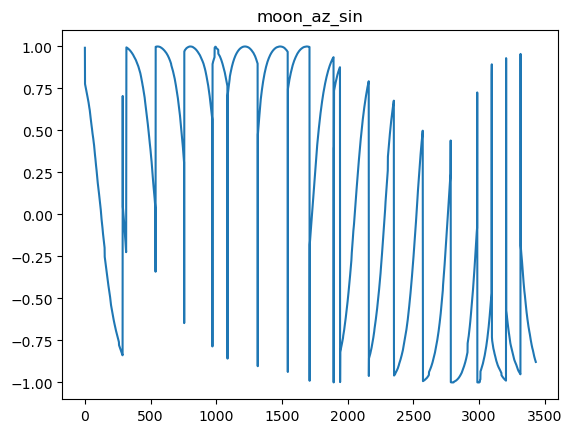

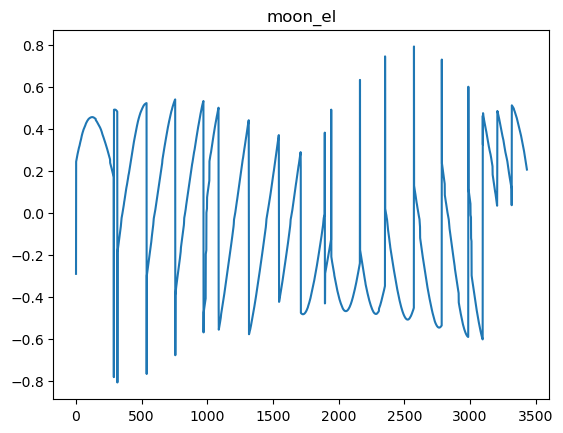

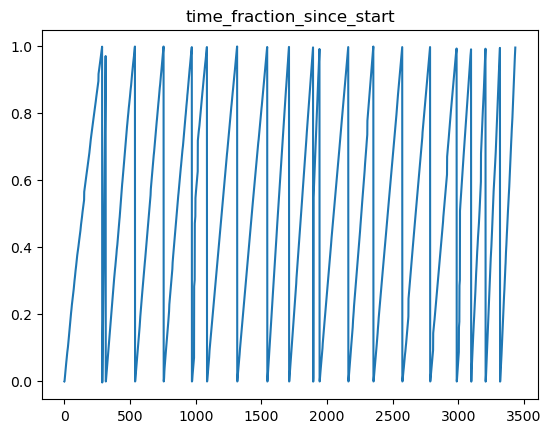

In [16]:
for feat_name, state in zip(dataset.state_feature_names, dataset.states.T):
    plt.plot(state)
    plt.title(feat_name)
    plt.show();

# Train

In [17]:
batch_size = 1024
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [18]:
"""Algorithm and Train setup"""
exp_name_prefix = 'v1f-environment-testing2'

bc_alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 4096//2//2,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**bc_alg_config)

# ddqn_alg_config = {
#     'obs_dim': dataset.obs_dim,
#     'num_actions': dataset.num_actions,
#     'hidden_dim': 128,
#     'device': device,
#     'gamma': .95,
#     'tau': 1e-4,
#     'lr': 1e-3,
#     'loss_fxn': None,
#     use_double=True,
# }
# alg = DDQN(**ddqn_alg_config)

fit_config = {
    'num_epochs' : 2,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, bc_alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)

# Train

In [19]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [20]:
import time

In [21]:
retrain = True

if os.path.exists(outdir + 'best_weights.pt') and not retrain:
    agent.load(filepath=outdir + 'best_weights.pt')
else:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s on {device}')

  0%|                                          | 1/6868 [00:00<26:30,  4.32it/s]

Train step 0: Accuracy = 0.011, Loss = 7.0820, Q-val=-0.442


  2%|▉                                      | 158/6868 [00:00<00:22, 293.75it/s]

Train step 100: Accuracy = 0.349, Loss = 2.0633, Q-val=-16.295


  4%|█▌                                     | 284/6868 [00:01<00:21, 312.28it/s]

Train step 200: Accuracy = 0.449, Loss = 1.6397, Q-val=-17.081


  5%|██                                     | 370/6868 [00:01<00:22, 284.50it/s]

Train step 300: Accuracy = 0.473, Loss = 1.4519, Q-val=-16.256


  6%|██▎                                    | 412/6868 [00:01<00:20, 313.76it/s]

Train step 400: Accuracy = 0.540, Loss = 1.2889, Q-val=-16.773


  8%|███                                    | 537/6868 [00:02<00:20, 312.97it/s]

Train step 500: Accuracy = 0.582, Loss = 1.0886, Q-val=-16.974


 10%|███▊                                   | 668/6868 [00:02<00:19, 322.95it/s]

Train step 600: Accuracy = 0.556, Loss = 1.1081, Q-val=-16.846


 10%|████                                   | 707/6868 [00:02<00:25, 242.74it/s]

Train step 700: Accuracy = 0.587, Loss = 1.0429, Q-val=-17.279


 12%|████▌                                  | 800/6868 [00:03<00:18, 324.60it/s]

Train step 800: Accuracy = 0.644, Loss = 0.8840, Q-val=-17.436


 14%|█████▌                                 | 978/6868 [00:03<00:16, 355.30it/s]

Train step 900: Accuracy = 0.638, Loss = 0.9228, Q-val=-17.436


 16%|█████▉                                | 1066/6868 [00:04<00:19, 299.65it/s]

Train step 1000: Accuracy = 0.652, Loss = 0.8676, Q-val=-18.103


 16%|██████                                | 1107/6868 [00:04<00:17, 323.64it/s]

Train step 1100: Accuracy = 0.686, Loss = 0.7813, Q-val=-17.869


 18%|██████▊                               | 1232/6868 [00:04<00:18, 312.27it/s]

Train step 1200: Accuracy = 0.715, Loss = 0.6754, Q-val=-17.997


 20%|███████▌                              | 1360/6868 [00:05<00:17, 320.27it/s]

Train step 1300: Accuracy = 0.721, Loss = 0.7264, Q-val=-18.320


 22%|████████▏                             | 1487/6868 [00:05<00:16, 320.74it/s]

Train step 1400: Accuracy = 0.718, Loss = 0.6536, Q-val=-18.548
Train step 1500: Accuracy = 0.762, Loss = 0.5721, Q-val=-18.794


 24%|████████▉                             | 1617/6868 [00:05<00:16, 318.46it/s]

Train step 1600: Accuracy = 0.751, Loss = 0.6218, Q-val=-18.811


 25%|█████████▋                            | 1746/6868 [00:06<00:16, 313.02it/s]

Train step 1700: Accuracy = 0.775, Loss = 0.5549, Q-val=-19.088


 27%|██████████▎                           | 1875/6868 [00:06<00:15, 312.85it/s]

Train step 1800: Accuracy = 0.790, Loss = 0.5064, Q-val=-19.256


 28%|██████████▌                           | 1916/6868 [00:07<00:14, 334.88it/s]

Train step 1900: Accuracy = 0.813, Loss = 0.4716, Q-val=-19.541


 29%|███████████                           | 1999/6868 [00:07<00:16, 292.67it/s]

Train step 2000: Accuracy = 0.795, Loss = 0.5105, Q-val=-19.435


 32%|████████████                          | 2172/6868 [00:07<00:14, 334.10it/s]

Train step 2100: Accuracy = 0.838, Loss = 0.3988, Q-val=-19.774


 33%|████████████▍                         | 2257/6868 [00:08<00:15, 290.85it/s]

Train step 2200: Accuracy = 0.829, Loss = 0.4478, Q-val=-19.842


 34%|████████████▋                         | 2302/6868 [00:08<00:14, 325.67it/s]

Train step 2300: Accuracy = 0.840, Loss = 0.4093, Q-val=-20.271


 35%|█████████████▍                        | 2426/6868 [00:08<00:14, 309.66it/s]

Train step 2400: Accuracy = 0.848, Loss = 0.3971, Q-val=-20.335


 37%|██████████████                        | 2545/6868 [00:09<00:14, 299.82it/s]

Train step 2500: Accuracy = 0.834, Loss = 0.3942, Q-val=-20.154


 39%|██████████████▊                       | 2676/6868 [00:09<00:14, 287.17it/s]

Train step 2600: Accuracy = 0.843, Loss = 0.3773, Q-val=-20.377


 40%|███████████████                       | 2715/6868 [00:09<00:13, 309.64it/s]

Train step 2700: Accuracy = 0.860, Loss = 0.3516, Q-val=-20.357


 41%|███████████████▋                      | 2839/6868 [00:10<00:13, 308.68it/s]

Train step 2800: Accuracy = 0.871, Loss = 0.3242, Q-val=-20.597


 43%|████████████████▍                     | 2968/6868 [00:10<00:12, 321.13it/s]

Train step 2900: Accuracy = 0.857, Loss = 0.3475, Q-val=-20.500


 44%|████████████████▉                     | 3054/6868 [00:11<00:13, 287.52it/s]

Train step 3000: Accuracy = 0.858, Loss = 0.3604, Q-val=-20.108


 45%|█████████████████▏                    | 3100/6868 [00:11<00:11, 324.57it/s]

Train step 3100: Accuracy = 0.866, Loss = 0.3198, Q-val=-21.000


 47%|█████████████████▊                    | 3224/6868 [00:11<00:11, 306.15it/s]

Train step 3200: Accuracy = 0.874, Loss = 0.3084, Q-val=-21.123


 49%|██████████████████▌                   | 3346/6868 [00:12<00:11, 306.61it/s]

Train step 3300: Accuracy = 0.882, Loss = 0.2886, Q-val=-20.986


 49%|██████████████████▊                   | 3392/6868 [00:12<00:10, 342.31it/s]

Train step 3400: Accuracy = 0.917, Loss = 0.2566, Q-val=-20.990


 51%|███████████████████▍                  | 3514/6868 [00:12<00:12, 260.62it/s]

Train step 3500: Accuracy = 0.911, Loss = 0.2312, Q-val=-20.910


 53%|████████████████████▏                 | 3642/6868 [00:13<00:10, 299.70it/s]

Train step 3600: Accuracy = 0.901, Loss = 0.2863, Q-val=-21.128


 55%|████████████████████▊                 | 3768/6868 [00:13<00:09, 311.76it/s]

Train step 3700: Accuracy = 0.907, Loss = 0.2254, Q-val=-20.997


 55%|█████████████████████                 | 3809/6868 [00:14<00:12, 242.02it/s]

Train step 3800: Accuracy = 0.871, Loss = 0.3296, Q-val=-21.263


 57%|█████████████████████▌                | 3900/6868 [00:14<00:09, 321.47it/s]

Train step 3900: Accuracy = 0.910, Loss = 0.2262, Q-val=-21.338


 59%|██████████████████████▎               | 4026/6868 [00:14<00:09, 314.04it/s]

Train step 4000: Accuracy = 0.911, Loss = 0.2154, Q-val=-21.507


 60%|██████████████████████▉               | 4155/6868 [00:15<00:08, 321.65it/s]

Train step 4100: Accuracy = 0.907, Loss = 0.2429, Q-val=-21.445


 61%|███████████████████████▏              | 4200/6868 [00:15<00:07, 351.42it/s]

Train step 4200: Accuracy = 0.913, Loss = 0.2317, Q-val=-21.293


 63%|███████████████████████▉              | 4326/6868 [00:15<00:07, 318.48it/s]

Train step 4300: Accuracy = 0.923, Loss = 0.2077, Q-val=-21.433


 65%|████████████████████████▋             | 4456/6868 [00:16<00:07, 321.83it/s]

Train step 4400: Accuracy = 0.890, Loss = 0.2812, Q-val=-21.175


 67%|█████████████████████████▎            | 4581/6868 [00:16<00:07, 317.16it/s]

Train step 4500: Accuracy = 0.938, Loss = 0.1744, Q-val=-21.595
Train step 4600: Accuracy = 0.921, Loss = 0.1881, Q-val=-22.243


 69%|██████████████████████████            | 4711/6868 [00:17<00:06, 320.10it/s]

Train step 4700: Accuracy = 0.931, Loss = 0.1924, Q-val=-21.623


 70%|██████████████████████████▊           | 4838/6868 [00:17<00:06, 315.87it/s]

Train step 4800: Accuracy = 0.911, Loss = 0.2212, Q-val=-21.802


 72%|███████████████████████████▍          | 4965/6868 [00:18<00:06, 316.35it/s]

Train step 4900: Accuracy = 0.921, Loss = 0.1924, Q-val=-21.754


 73%|███████████████████████████▋          | 5009/6868 [00:18<00:05, 344.51it/s]

Train step 5000: Accuracy = 0.933, Loss = 0.1901, Q-val=-22.179


 75%|████████████████████████████▍         | 5139/6868 [00:18<00:05, 324.98it/s]

Train step 5100: Accuracy = 0.921, Loss = 0.2006, Q-val=-21.597


 77%|█████████████████████████████▏        | 5265/6868 [00:19<00:05, 313.29it/s]

Train step 5200: Accuracy = 0.927, Loss = 0.2133, Q-val=-22.152


 78%|█████████████████████████████▌        | 5349/6868 [00:19<00:05, 270.31it/s]

Train step 5300: Accuracy = 0.933, Loss = 0.1634, Q-val=-22.308


 79%|█████████████████████████████▊        | 5394/6868 [00:19<00:04, 308.48it/s]

Train step 5400: Accuracy = 0.921, Loss = 0.2001, Q-val=-22.225


 80%|██████████████████████████████▌       | 5522/6868 [00:20<00:04, 312.88it/s]

Train step 5500: Accuracy = 0.920, Loss = 0.2267, Q-val=-22.404


 82%|███████████████████████████████▎      | 5649/6868 [00:20<00:04, 266.09it/s]

Train step 5600: Accuracy = 0.936, Loss = 0.1729, Q-val=-22.767


 84%|███████████████████████████████▉      | 5780/6868 [00:21<00:04, 260.43it/s]

Train step 5700: Accuracy = 0.930, Loss = 0.1732, Q-val=-22.213


 85%|████████████████████████████████▏     | 5826/6868 [00:21<00:03, 299.91it/s]

Train step 5800: Accuracy = 0.932, Loss = 0.2217, Q-val=-22.822


 87%|████████████████████████████████▉     | 5953/6868 [00:21<00:02, 309.01it/s]

Train step 5900: Accuracy = 0.949, Loss = 0.1464, Q-val=-22.944


 88%|█████████████████████████████████▍    | 6037/6868 [00:22<00:02, 281.43it/s]

Train step 6000: Accuracy = 0.943, Loss = 0.1759, Q-val=-22.897


 90%|██████████████████████████████████▏   | 6179/6868 [00:22<00:02, 317.91it/s]

Train step 6100: Accuracy = 0.924, Loss = 0.1718, Q-val=-22.743


 91%|██████████████████████████████████▍   | 6218/6868 [00:22<00:01, 333.75it/s]

Train step 6200: Accuracy = 0.959, Loss = 0.1249, Q-val=-23.159


 92%|███████████████████████████████████▏  | 6350/6868 [00:23<00:01, 330.25it/s]

Train step 6300: Accuracy = 0.953, Loss = 0.1276, Q-val=-23.131


 94%|███████████████████████████████████▊  | 6480/6868 [00:23<00:01, 280.21it/s]

Train step 6400: Accuracy = 0.950, Loss = 0.1426, Q-val=-23.182


 96%|████████████████████████████████████▎ | 6564/6868 [00:24<00:01, 269.92it/s]

Train step 6500: Accuracy = 0.944, Loss = 0.1343, Q-val=-23.424


 96%|████████████████████████████████████▌ | 6605/6868 [00:24<00:00, 299.25it/s]

Train step 6600: Accuracy = 0.968, Loss = 0.1001, Q-val=-23.366


 98%|█████████████████████████████████████▎| 6735/6868 [00:24<00:00, 272.74it/s]

Train step 6700: Accuracy = 0.940, Loss = 0.1520, Q-val=-23.359


100%|██████████████████████████████████████| 6868/6868 [00:25<00:00, 267.89it/s]

Train step 6800: Accuracy = 0.938, Loss = 0.1969, Q-val=-23.129
Total train time = 25.758641481399536s on cuda


In [22]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

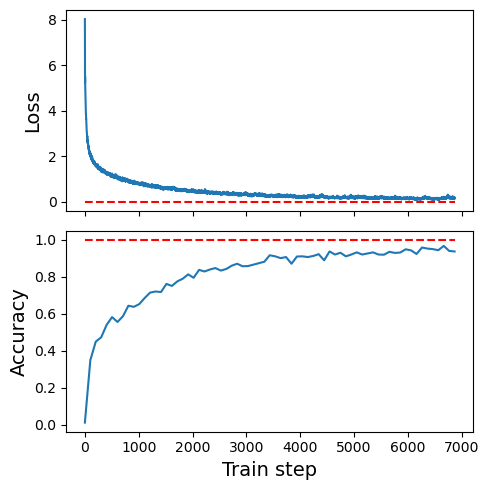

In [23]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy on train dataset

## Using gym.env

In [52]:
train_dataset_subset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[specific_years[-1]],
    specific_months=[specific_months[-1]],
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
    do_max_norm=do_max_norm,
    do_inverse_airmass=do_inverse_airmass
)

/home/hurra/Projects/survey-ops/survey_ops/src/offline_dataset.py:356: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, zenith_df], ignore_index=True)


In [53]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2014],
    specific_months=[12],
    specific_days=[30],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

/home/hurra/Projects/survey-ops/survey_ops/src/offline_dataset.py:356: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, zenith_df], ignore_index=True)


In [54]:
from survey_ops.src.environments import OfflineEnv

In [55]:
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=OfflineEnv,
    #max_episode_steps=1000000,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'train_dataset': dataset,
    'test_dataset': test_dataset,
    'max_nights': None,
    'field_choice_method': 'random',
}

env = gym.make(**env_config)

/home/hurra/.conda/envs/cosmoML/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment gymnasium_env/OfflineEnv already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Some small checks of environment

In [72]:
for a, b in zip(dataset._df['el'].values, np.pi/2 - dataset._df['zd'].values):
    print(type(a), type(b), a, b, a == b)

<class 'numpy.float32'> <class 'numpy.float32'> 1.1911873 1.1911873 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.8002335 0.8002335 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.8794714 0.8794715 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.81698865 0.81698865 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.8121017 0.8121017 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.805993 0.8059931 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.82292277 0.82292277 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.8002335 0.8002335 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.8045968 0.80459684 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.7988372 0.79883724 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.81663954 0.8166396 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.8114036 0.81140363 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.8049458 0.8049459 False
<class 'numpy.float32'> <class 'numpy

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [83]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin', 'field_id'],
      dtype='object')

In [48]:
env.unwrapped.pd_nightgroup.head(1)[dataset.state_feature_names]

ra_cos    ra_sin      dec  az_cos  az_sin        el  airmass  ha_cos  \
3416 -0.775367  0.631511 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3417 -0.260270  0.965536 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3418  0.640356  0.768078 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3419  0.684373  0.729132 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3420 -0.977982  0.208692 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3421  0.547191  0.837008 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3422  0.529932  0.848040 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3423  0.517202  0.855864 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3424  0.485793  0.874074 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3425  0.473771  0.880648 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3426  0.449782  0.893138 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3427 -0.996850  0.079308 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3428  0.399766  0.916617 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3429  0.395758  0.918355 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3430  0.275128  0.961408 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3431 -0.999230  0.039247 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3432  0.171994  0.985098 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3433  0.253133  0.967431 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3434 -0.997506  0.070574 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3435 -0.602778  0.797909 -0.52656     1.0     0.0  1.570796      1.0     1.0   
3436 -0.538867  0.842391 -0.52656     1.0     0.0  1.570796      1.0     1.0   

      ha_sin  sun_ra_cos  ...  sun_az_cos  sun_az_sin    sun_el  moon_ra_cos  \
3416     0.0   -0.796992  ...    0.426088    0.904682  1.054680     0.910596   
3417     0.0   -0.788045  ...    0.404016    0.914752  1.045863     0.978830   
3418     0.0   -0.779005  ...    0.382633    0.923901  1.036892     0.999999   
3419     0.0   -0.768207  ...    0.358229    0.933634  1.026121     0.973167   
3420     0.0   -0.680181  ...    0.197010    0.980402  0.938063    -0.392718   
3421     0.0   -0.671157  ...    0.183515    0.983017  0.929138    -0.504933   
3422     0.0   -0.657847  ...    0.164477    0.986381  0.916018    -0.672839   
3423     0.0   -0.644293  ...    0.146030    0.989280  0.902728    -0.807907   
3424     0.0   -0.630439  ...    0.128081    0.991764  0.889222    -0.908670   
3425     0.0   -0.616381  ...    0.110736    0.993850  0.875602    -0.972914   
3426     0.0   -0.602044  ...    0.093875    0.995584  0.861801    -0.999429   
3427     0.0   -0.582952  ...    0.072641    0.997358  0.843557    -0.969467   
3428     0.0   -0.572630  ...    0.061642    0.998098  0.833772    -0.928037   
3429     0.0   -0.557616  ...    0.046287    0.998928  0.819613    -0.824009   
3430     0.0   -0.494981  ...   -0.011108    0.999938  0.761580     0.023191   
3431     0.0   -0.474164  ...   -0.028140    0.999604  0.742638     0.332263   
3432     0.0   -0.462228  ...   -0.037557    0.999295  0.731863     0.517775   
3433     0.0   -0.445893  ...   -0.049986    0.998750  0.717192     0.712765   
3434     0.0   -0.424438  ...   -0.065597    0.997846  0.698057     0.882637   
3435     0.0   -0.409771  ...   -0.075881    0.997117  0.685075     0.963454   
3436     0.0   -0.392829  ...   -0.087354    0.996177  0.670160     0.999289   

      moon_ra_sin  moon_dec  moon_az_cos  moon_az_sin   moon_el  \
3416    -0.413297 -0.099793    -0.666423     0.745574 -0.725822   
3417    -0.204675 -0.032346    -0.803069     0.595886 -0.909375   
3418    -0.001240  0.035100    -0.939198     0.343377 -1.055978   
3419     0.230100  0.111158    -0.987822    -0.155586 -1.153580   
3420     0.919659  0.296019     0.364061    -0.931375  0.051166   
3421     0.863158  0.269879     0.406021    -0.913864  0.163567   
3422     0.739789

In [47]:
env.unwrapped._state

array([-0.77536666,  0.63151133, -0.52655995,  1.        ,  0.        ,
        1.5707964 ,  1.        ,  1.        ,  0.        , -0.7969916 ,
       -0.60399044, -0.25604004,  0.4260882 ,  0.9046816 ,  1.0546805 ,
        0.91059643, -0.41329667, -0.09979261, -0.66642267,  0.7455742 ,
       -0.72582185,  0.        ], dtype=float32)

In [49]:
env.unwrapped.test_dataset.states[0]

tensor([ 0.7369,  0.6759, -0.4768, -0.0083, -1.0000,  1.1320,  1.1000, -0.9450,
        -0.3272, -0.7970, -0.6040, -0.2560, -0.6762, -0.7367, -0.5245,  0.9106,
        -0.4133, -0.0998,  0.7433, -0.6689,  1.0280,  0.0000])

In [70]:
env.unwrapped._bin_num

np.int32(2146)

In [71]:
test_dataset._df.bin[:2]

27072    2146
27073    2018
Name: bin, dtype: int32

In [67]:
state, info = env.reset()

In [55]:
train_dataset_subset.states[0]

tensor([ 0.7369,  0.6759, -0.4768, -0.0083, -1.0000,  1.1320,  1.1000, -0.9450,
        -0.3272, -0.7970, -0.6040, -0.2560, -0.6762, -0.7367, -0.5245,  0.9106,
        -0.4133, -0.0998,  0.7433, -0.6689,  1.0280,  0.0000])

In [72]:
next_state, reward, terminated, truncated, info = env.step(16282)

In [74]:
for b, feat_name in zip(train_dataset_subset.next_states[1] == next_state, train_dataset_subset.state_feature_names):
    print(feat_name, b)

ra_cos tensor(False)
ra_sin tensor(False)
dec tensor(False)
az_cos tensor(False)
az_sin tensor(False)
el tensor(False)
airmass tensor(False)
ha_cos tensor(False)
ha_sin tensor(False)
sun_ra_cos tensor(False)
sun_ra_sin tensor(False)
sun_dec tensor(False)
sun_az_cos tensor(False)
sun_az_sin tensor(False)
sun_el tensor(False)
moon_ra_cos tensor(False)
moon_ra_sin tensor(False)
moon_dec tensor(False)
moon_az_cos tensor(False)
moon_az_sin tensor(False)
moon_el tensor(False)
time_fraction_since_start tensor(False)


In [54]:
state, info = env.reset()

In [78]:
env.reset()

(array([-7.7536666e-01,  6.3151133e-01, -5.2655995e-01,  1.0000000e+00,
         0.0000000e+00,  1.5707964e+00,  1.0000000e+00,  1.0000000e+00,
         0.0000000e+00, -7.9699159e-01, -6.0399044e-01, -2.5604004e-01,
         4.8097724e-01,  8.7673306e-01,  1.0933812e+00,  9.1059643e-01,
        -4.1329667e-01, -9.9792607e-02, -6.2878692e-01,  7.7757770e-01,
        -6.9272757e-01, -1.3657471e-03], dtype=float32),
 {'action_mask': array([False, False, False, ..., False, False, False], shape=(49152,))})

In [45]:
(np.argwhere(env.unwrapped._action_mask == True) == 36810).flatten()

array([False, False, False, ..., False, False, False], shape=(6018,))

In [49]:
env.unwrapped._bin_num

np.int32(36810)

In [60]:
state, info = env.reset()
episode_reward = 0
terminated = False
truncated = False
state_list = [state]
rewards_list = [0]
actions = []

i = 0
while not (terminated or truncated):
    with torch.no_grad():
        # if env.unwrapped._night_idx != 0:
        #     print(env.unwrapped._night_idx)
        action_mask = info.get('action_mask', None)
        action = agent.act(state, action_mask, epsilon=None)  # greedy
        actions.append(action)
        state, reward, terminated, truncated, info = env.step(action)
        state_list.append(state)
        # rewards_list.append(reward)
        # episode_reward += reward
        i += 1
        # if i==1:
        #     break

In [81]:
env.unwrapped.test_dataset.states[0]

tensor([-7.7537e-01,  6.3151e-01, -5.2656e-01,  1.0000e+00,  0.0000e+00,
         1.5708e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00, -7.9699e-01,
        -6.0399e-01, -2.5604e-01,  5.9589e-01,  8.0307e-01,  1.1604e+00,
         9.1060e-01, -4.1330e-01, -9.9793e-02, -5.6204e-01,  8.2711e-01,
        -6.2882e-01, -1.3657e-03])

In [83]:
state_list[0]

array([-7.7536666e-01,  6.3151133e-01, -5.2655995e-01,  1.0000000e+00,
        0.0000000e+00,  1.5707964e+00,  1.0000000e+00,  1.0000000e+00,
        0.0000000e+00, -7.9699159e-01, -6.0399044e-01, -2.5604004e-01,
        4.9422961e-01,  8.6933142e-01,  1.1020195e+00,  9.1059643e-01,
       -4.1329667e-01, -9.9792607e-02, -6.2031806e-01,  7.8435040e-01,
       -6.8499756e-01, -1.3657471e-03], dtype=float32)

## Evaluate agent given environment

In [56]:
from survey_ops.utils import ephemerides

In [88]:
state, info = env.reset()

In [96]:
env.unwrapped.test_dataset.states[0]

tensor([-3.9640e-01,  9.1808e-01, -3.3522e-01,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  1.7482e-01,
        -9.8460e-01, -2.5678e-01, -1.6472e-02, -9.9986e-01,  5.5162e-01,
         8.0854e-01,  5.8845e-01,  1.4412e-01,  3.5804e-01,  9.3370e-01,
         1.0178e-01, -7.9045e-04])

In [99]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.11it/s]

terminated at 106
eval_metrics.pkl saved in ../results/v1f-environment-testing2BehaviorCloning-OfflineEnv-n_nights=21-num_epochs=2-batch_size=1024-lr=0.003/


/tmp/ipykernel_112815/3156405144.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ax.legend()


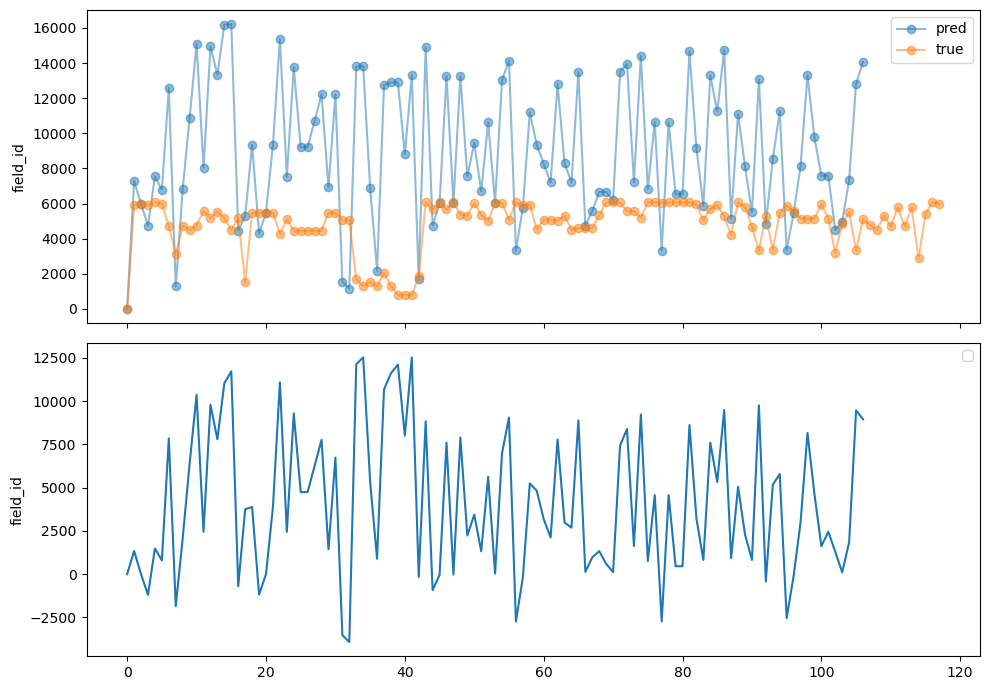

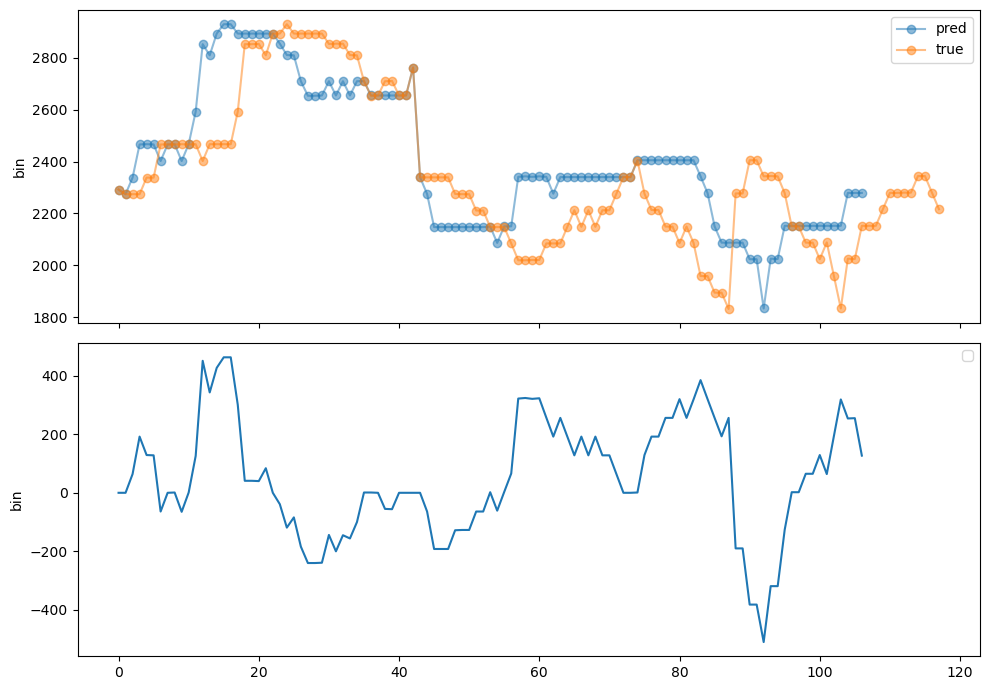

In [100]:
fig_f, axs_f = plt.subplots(2, figsize=(10,7), sharex=True)
fig_b, axs_b = plt.subplots(2, figsize=(10,7), sharex=True)
for ax, metric in zip([axs_f, axs_b], ['field_id', 'bin']):
    ax[0].plot(eval_metrics[metric]['ep-0'].astype(int), marker='o', label='pred', alpha=.5)
    ax[0].plot(env.unwrapped.test_dataset._df[metric].values.astype(int), marker='o', label='true', alpha=.5)
    ax[1].plot(eval_metrics[metric]['ep-0'].astype(int)[:len(env.unwrapped.test_dataset._df[metric].values.astype(int))] - env.unwrapped.test_dataset._df[metric].values.astype(int)[:len(eval_metrics[metric]['ep-0'].astype(int))])
    for _ax in ax:
        _ax.set_ylabel(metric)
        _ax.legend()
fig_f.tight_layout()
fig_b.tight_layout()

In [107]:
env.unwrapped.test_dataset.states.shape

torch.Size([117, 22])

In [122]:
torch.cat([torch.tensor([env.unwrapped.test_dataset.states[0, i]]), env.unwrapped.test_dataset.next_states[:, i]])

torch.Size([118])

In [120]:
torch.tensor([env.unwrapped.test_dataset.states[0, i]])

tensor([-0.3964])

In [113]:
a = torch.tensor([1])

In [114]:
a

tensor([1])

In [115]:
a[:, np.newaxis]

tensor([[1]])

In [109]:
env.unwrapped.test_dataset.next_states[:, i].shape

torch.Size([117])

In [125]:
env.unwrapped.test_dataset._df.airmass

117    1.00
0      1.12
1      1.12
2      1.11
3      1.12
       ... 
112    1.30
113    1.35
114    1.37
115    1.36
116    1.37
Name: airmass, Length: 118, dtype: float32

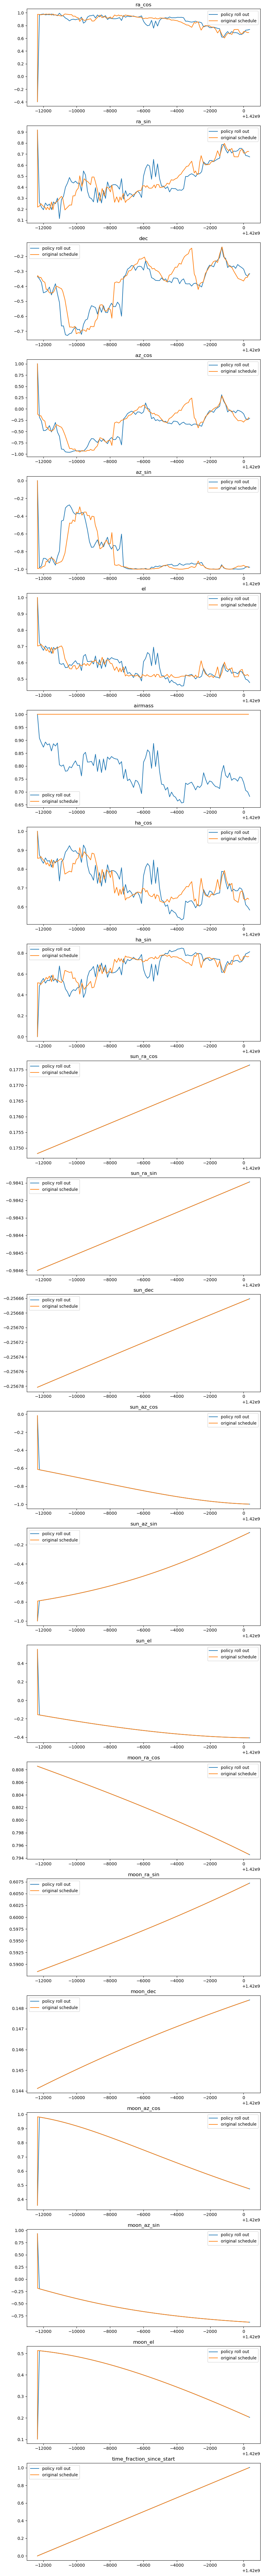

In [124]:
fig, axs = plt.subplots(len(dataset.state_feature_names), figsize=(10, len(dataset.state_feature_names)*5))
for i, feature_row in enumerate(eval_metrics['observations']['ep-0'].T):
    axs[i].plot(eval_metrics['timestamps']['ep-0'], feature_row, label='policy roll out')
    orig_state = torch.cat([torch.tensor([env.unwrapped.test_dataset.states[0, i]]), env.unwrapped.test_dataset.next_states[:, i]])
    axs[i].plot(env.unwrapped.test_dataset._df['timestamp'], orig_state, label='original schedule')
    axs[i].set_title(env.unwrapped.test_dataset.state_feature_names[i])
    axs[i].legend()


In [126]:
eval_bin_radecs = np.array([env.unwrapped.test_dataset.bin2radec[bin_num] for bin_num in eval_metrics['bin']['ep-0'].astype(int) if bin_num != -1])
orig_bin_radecs = np.array([env.unwrapped.test_dataset.bin2radec[bin_num] for bin_num in env.unwrapped.test_dataset._df['bin'].values if bin_num != -1])

eval_field_radecs = np.array([env.unwrapped.test_dataset.field2radec[field_id] for field_id in eval_metrics['field_id']['ep-0'].astype(int) if field_id != -1])
orig_field_radecs = np.array([env.unwrapped.test_dataset.field2radec[field_id] for field_id in env.unwrapped.test_dataset._df['field_id'].values.astype(int) if field_id != -1])

Text(0.5, 0.98, 'Fields')

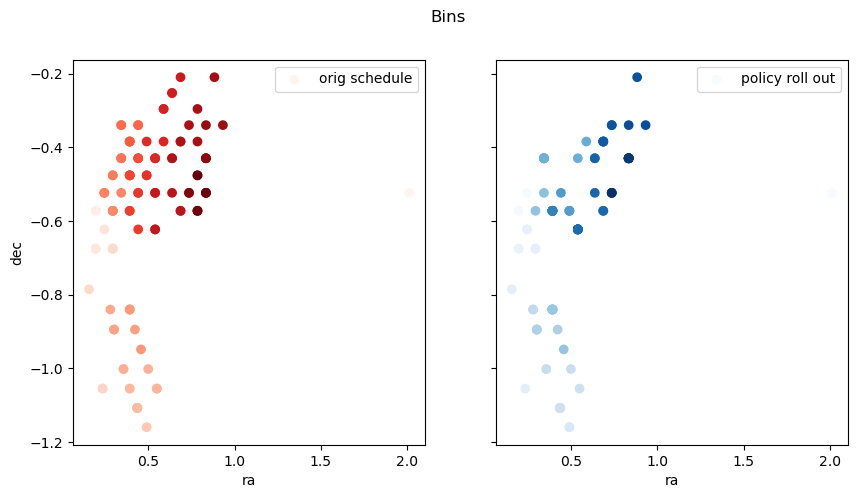

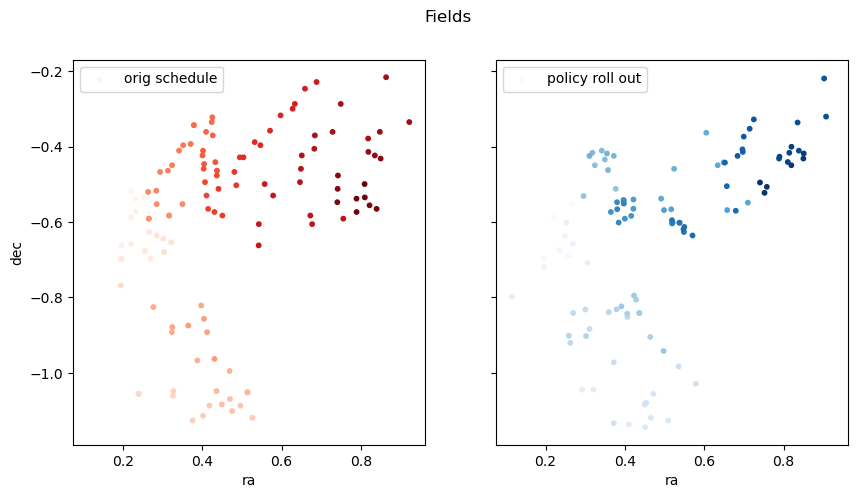

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
axs[0].scatter(orig_bin_radecs[:, 0], orig_bin_radecs[:, 1], label='orig schedule', cmap='Reds', c=np.arange(len(orig_bin_radecs)))
axs[1].scatter(eval_bin_radecs[:, 0], eval_bin_radecs[:, 1], label='policy roll out', cmap='Blues', c=np.arange(len(eval_bin_radecs)))
for ax in axs:
    ax.set_xlabel('ra')
    ax.legend()
axs[0].set_ylabel('dec')
fig.suptitle('Bins')

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
axs[0].scatter(orig_field_radecs[:, 0], orig_field_radecs[:, 1], label='orig schedule', cmap='Reds', c=np.arange(len(orig_field_radecs)), s=10)
axs[1].scatter(eval_field_radecs[:, 0], eval_field_radecs[:, 1], label='policy roll out', cmap='Blues', c=np.arange(len(eval_field_radecs)), s=10)
for ax in axs:
    ax.set_xlabel('ra')
    ax.legend()
axs[0].set_ylabel('dec')
fig.suptitle('Fields')

In [130]:
eval_metrics['bin']['ep-0']

array([2292, 2274, 2338, 2466, 2467, 2466, 2402, 2466, 2467, 2402, 2467,
       2593, 2853, 2810, 2894, 2930, 2930, 2894, 2894, 2894, 2894, 2894,
       2894, 2855, 2811, 2810, 2710, 2654, 2654, 2655, 2710, 2655, 2710,
       2655, 2710, 2711, 2655, 2655, 2655, 2655, 2655, 2655, 2763, 2339,
       2275, 2147, 2147, 2147, 2147, 2147, 2147, 2147, 2147, 2149, 2086,
       2150, 2150, 2341, 2343, 2341, 2343, 2341, 2276, 2340, 2340, 2340,
       2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2405, 2405, 2405,
       2405, 2405, 2405, 2405, 2405, 2405, 2343, 2278, 2150, 2087, 2087,
       2087, 2087, 2023, 2023, 1833, 2025, 2024, 2152, 2152, 2152, 2152,
       2152, 2152, 2152, 2152, 2152, 2279, 2279, 2279])

In [133]:
nside

16

In [141]:
bin_schedule

{'time': 117    1419987649
 0      1419987659
 1      1419987779
 2      1419987853
 3      1419987977
           ...    
 112    1419999923
 113    1419999999
 114    1420000118
 115    1420000235
 116    1420000310
 Name: timestamp, Length: 118, dtype: int32,
 'policy_bin_id': array([2292, 2274, 2338, 2466, 2467, 2466, 2402, 2466, 2467, 2402, 2467,
        2593, 2853, 2810, 2894, 2930, 2930, 2894, 2894, 2894, 2894, 2894,
        2894, 2855, 2811, 2810, 2710, 2654, 2654, 2655, 2710, 2655, 2710,
        2655, 2710, 2711, 2655, 2655, 2655, 2655, 2655, 2655, 2763, 2339,
        2275, 2147, 2147, 2147, 2147, 2147, 2147, 2147, 2147, 2149, 2086,
        2150, 2150, 2341, 2343, 2341, 2343, 2341, 2276, 2340, 2340, 2340,
        2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2405, 2405, 2405,
        2405, 2405, 2405, 2405, 2405, 2405, 2343, 2278, 2150, 2087, 2087,
        2087, 2087, 2023, 2023, 1833, 2025, 2024, 2152, 2152, 2152, 2152,
        2152, 2152, 2152, 2152, 2152, 2279, 2279, 2279]

In [156]:
_df['policy_bin_id'].fillna(10)

0      2292.0
1      2274.0
2      2338.0
3      2466.0
4      2467.0
        ...  
113      10.0
114      10.0
115      10.0
116      10.0
117      10.0
Name: policy_bin_id, Length: 118, dtype: float64

In [158]:
save_schedules = True
if save_schedules:
    _timestamps = eval_metrics['timestamps']['ep-0'] \
                  if len(eval_metrics['timestamps']['ep-0']) > len(env.unwrapped.test_dataset._df['timestamp']) \
                  else env.unwrapped.test_dataset._df['timestamp'] 
    eval_field_schedule = {
        'time': _timestamps,
        'field_id': eval_metrics['field_id']['ep-0']
    }
    
    orig_field_schedule = {
        'time': _timestamps,
        'field_id': env.unwrapped.test_dataset._df['field_id'].values
    }
    
    # bin_schedule = {
    #     'time': train_dataset_subset._df['timestamp'].values[:len(eval_metrics['timestamps']['ep-0'])],
    #     'policy_bin_id': eval_metrics['bin']['ep-0'][:len(train_dataset_subset._df['bin'].values)],
    #     'bin_id': train_dataset_subset._df['bin'].values[:len(eval_metrics['timestamps']['ep-0'])]
    # }

    
    bin_schedule = {
        'time': _timestamps,
        'policy_bin_id': eval_metrics['bin']['ep-0'].astype(np.int32),
        'bin_id': env.unwrapped.test_dataset._df['bin'].values
    }
    
    schedule_outdir = '../results/v2f-environment-testing/'
    if not os.path.exists(schedule_outdir):
        os.makedirs(schedule_outdir)
    for data, filename in zip(
        [orig_field_schedule, eval_field_schedule, bin_schedule],
        ['original_schedule.csv', 'eval_schedule.csv', 'bin_schedule.csv']
        ):
        series_data = {key: pd.Series(value) for key, value in data.items()}
        _df = pd.DataFrame(series_data)
        if 'bin' in filename:
            _df['policy_bin_id'] = _df['policy_bin_id'].fillna(0).astype('Int64')
            print(_df.tail(15))
        output_filepath = '../results/v2f-environment-testing/' + filename
        with open(output_filepath, 'w') as f:
            _df.to_csv(f, index=False)

           time  policy_bin_id  bin_id
103  1419998858           2152    1833
104  1419998988           2279    2025
105  1419999109           2279    2024
106  1419999228           2279    2152
107  1419999303              0    2152
108  1419999438              0    2152
109  1419999557              0    2216
110  1419999677              0    2279
111  1419999804              0    2279
112  1419999923              0    2280
113  1419999999              0    2280
114  1420000118              0    2344
115  1420000235              0    2344
116  1420000310              0    2280
117  1419987649              0    2216


In [109]:
# schedule file: columns `time` and `field_id`
# bin_schedule file: "time", "policy_bin_id", and "bin_id"

## Instead of trajectory, send agent batch of all states to get best next action

In [121]:
specific_years, specific_months, specific_days

([2014], [12], None)

In [142]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2014],
    specific_months=[12],
    specific_days=[30],obs
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

/home/hurra/Projects/survey-ops/survey_ops/src/offline_dataset.py:356: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, zenith_df], ignore_index=True)


In [143]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu').detach().numpy()
    

In [144]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in test_dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [145]:
# Sequence of actions from target (original schedule) and policy
target_sequence = test_dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

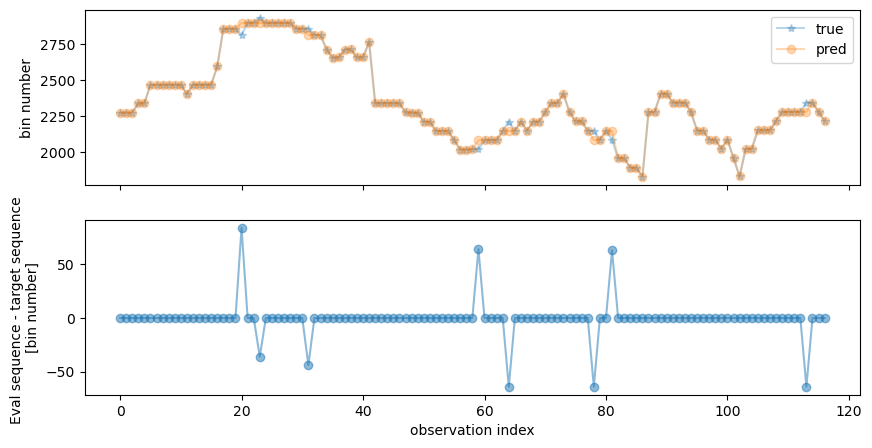

In [146]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(target_sequence, marker='*', alpha=.3, label='true')
axs[0].plot(eval_sequence, marker='o', alpha=.3, label='pred')
axs[0].legend()
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence \n[bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [147]:
eval_sequence

array([2274, 2274, 2274, 2338, 2338, 2466, 2466, 2466, 2467, 2466, 2467,
       2402, 2467, 2467, 2467, 2467, 2593, 2853, 2853, 2854, 2894, 2894,
       2894, 2894, 2894, 2894, 2894, 2894, 2894, 2854, 2855, 2811, 2811,
       2810, 2710, 2654, 2655, 2710, 2711, 2655, 2655, 2763, 2339, 2339,
       2339, 2339, 2339, 2275, 2274, 2274, 2211, 2211, 2147, 2147, 2147,
       2084, 2019, 2019, 2020, 2084, 2084, 2084, 2084, 2148, 2148, 2148,
       2212, 2148, 2212, 2212, 2276, 2340, 2340, 2404, 2276, 2213, 2213,
       2149, 2085, 2085, 2149, 2149, 1958, 1958, 1894, 1894, 1831, 2277,
       2277, 2405, 2405, 2343, 2344, 2343, 2278, 2150, 2150, 2087, 2087,
       2023, 2088, 1960, 1833, 2025, 2024, 2152, 2152, 2152, 2216, 2279,
       2279, 2280, 2280, 2280, 2344, 2280, 2216])

In [148]:
target_sequence

array([2274, 2274, 2274, 2338, 2338, 2466, 2466, 2466, 2467, 2466, 2467,
       2402, 2467, 2467, 2467, 2467, 2593, 2853, 2853, 2854, 2810, 2894,
       2894, 2930, 2894, 2894, 2894, 2894, 2894, 2854, 2855, 2855, 2811,
       2810, 2710, 2654, 2655, 2710, 2711, 2655, 2655, 2763, 2339, 2339,
       2339, 2339, 2339, 2275, 2274, 2274, 2211, 2211, 2147, 2147, 2147,
       2084, 2019, 2019, 2020, 2020, 2084, 2084, 2084, 2148, 2212, 2148,
       2212, 2148, 2212, 2212, 2276, 2340, 2340, 2404, 2276, 2213, 2213,
       2149, 2149, 2085, 2149, 2086, 1958, 1958, 1894, 1894, 1831, 2277,
       2277, 2405, 2405, 2343, 2344, 2343, 2278, 2150, 2150, 2087, 2087,
       2023, 2088, 1960, 1833, 2025, 2024, 2152, 2152, 2152, 2216, 2279,
       2279, 2280, 2280, 2344, 2344, 2280, 2216], dtype=int32)

In [149]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in target_sequence])

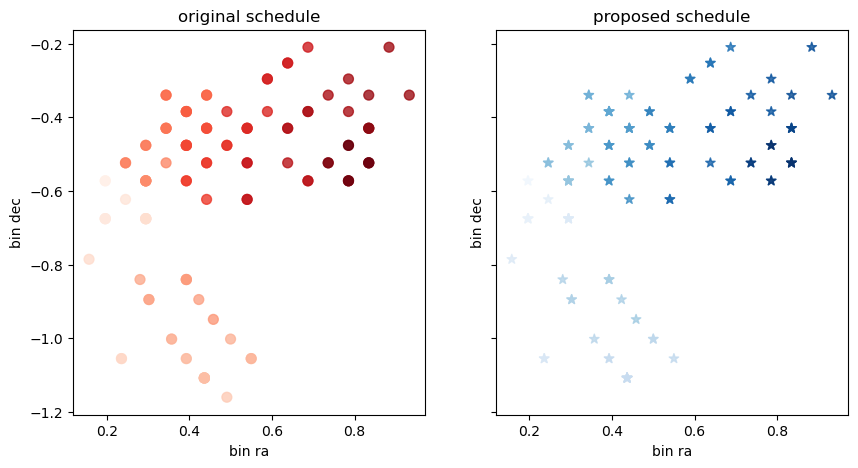

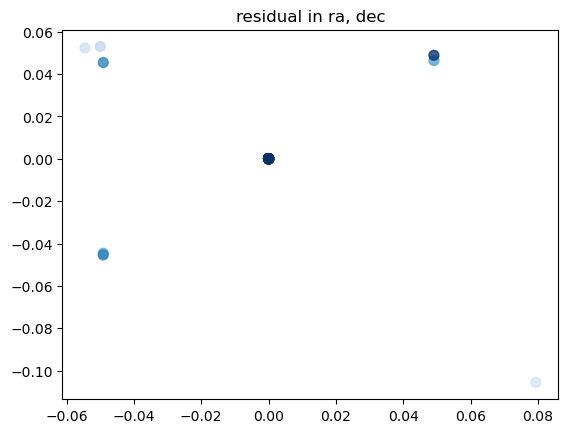

In [150]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], cmap='Reds', s=50, alpha=.8, c=np.arange(len(test_target_bin_radecs)))
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], cmap='Blues', alpha=.8, s=50, marker='*', c=np.arange(len(test_eval_bin_radecs)))
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
for ax in axs:
    ax.set_xlabel('bin ra')
    ax.set_ylabel('bin dec')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], cmap='Blues', s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();


In [151]:
save_schedules = True
if save_schedules:
    eval_field_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'field_id': eval_sequence
    }
    orig_field_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'field_id': target_sequence
    }
    bin_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'policy_bin_id': eval_sequence,
        'bin_id': target_sequence
    }
    
    schedule_outdir = '../results/v2f-environment-testing/'
    if not os.path.exists(schedule_outdir):
        os.makedirs(schedule_outdir)
    for data, filename in zip(
        [orig_field_schedule, eval_field_schedule, bin_schedule],
        ['original_schedule.csv', 'eval_schedule.csv', 'bin_schedule.csv']
        ):
        _df = pd.DataFrame(data)
        output_filepath = '../results/v2f-environment-testing/' + filename
        with open(output_filepath, 'w') as f:
            _df.to_csv(f, index=False)